In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from IMPA.model import build_model

from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import yaml

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/mol2image/models")
from proglow import build_proglow_model

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

**Read yaml files**

In [3]:
def count_IMPA_parameters(num_domains, single_style):
    args = {"img_size": 96, 
            "style_dim": 128,
            "n_channels": 6, 
            "dim_in": 64,
            "single_style": single_style,
            "stochastic": True, 
            "latent_dim": 512, 
            "z_dimension": 64, 
            "num_layers_mapping_net": 1}
    
    num_domains = num_domains
    args_dict = OmegaConf.create(args)
    model = build_model(args_dict, num_domains, "cuda")
    c = 0
    for m in model:
        c += count_params(model[m])
    del model
    # Free GPU memory
    torch.cuda.empty_cache()
    return c

def count_mol2image_parameters(num_domains):
    args_mol2image = {"modules": [{"type": "cond_proglowmpn", 
                "n_flow": 32, 
                "n_block": 1, 
                "in_channel": 6, 
                "img_size": 64, 
                "checkpoint": "/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/results/mol2img/karren_weights/64.pth", 
                "n_cond": 512}, 
                {"type": "cond_proglowmpn", 
                         "n_flow": 32,
                         "n_block": 1, 
                         "in_channel": 5, 
                         "img_size": 32, 
                         "checkpoint": "/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/results/mol2img/karren_weights/32.pth", "n_cond": 512}, 
                {"type": "cond_glowmpn", 
                         "n_flow": 32, 
                         "n_block": 2, 
                         "in_channel": 5, 
                         "img_size": 16, 
                         "checkpoint": "/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/results/mol2img/karren_weights/16.pth", "n_cond": 512}], 
                "z_shapes": [[15, 32, 32], [15, 16, 16], [10, 8, 8], [40, 4, 4]], 
                "temp": [1.0, 1.0, 1.0, 1.0]}
    net = build_proglow_model(args_mol2image["modules"], affine=True).to("cuda")
    net.freeze_base_blocks()
    return count_params(net)

In [4]:
def initialize_model_and_compute_memory(yaml_config):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, ".", dataloader_rdkit)
    return solver_rdkit

def count_params(model):
    n_params = sum(p.numel() for p in model.parameters())
    return n_params

Get the memory plot

In [5]:
results = {"number of parameters": [],
          "model": [],
          "number of molecules": []
         }

for number_of_domains in [100, 500, 1000, 5000, 10000, 50000]:
    # IMPA
    c_IMPA = count_IMPA_parameters(number_of_domains, True)
    results["model"].append("IMPA")
    results["number of molecules"].append(number_of_domains)
    results["number of parameters"].append(c_IMPA)
    # starganv2
    if number_of_domains < 10000:
        c_starganv2 = count_IMPA_parameters(number_of_domains, False)
        results["model"].append("starGANv2")
        results["number of molecules"].append(number_of_domains)
        results["number of parameters"].append(c_starganv2)
    # mol2image
    c_mol2image = count_mol2image_parameters(number_of_domains)
    results["model"].append("Mol2Image")
    results["number of molecules"].append(number_of_domains)
    results["number of parameters"].append(c_mol2image)

/home/icb/alessandro.palma/environment/IMPA/mol2image/models/glow.py:108: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  w_s = torch.from_numpy(w_s)


In [6]:
results_df = pd.DataFrame(results) 

In [7]:
results_df["number of parameters"] =  np.log(results_df["number of parameters"])

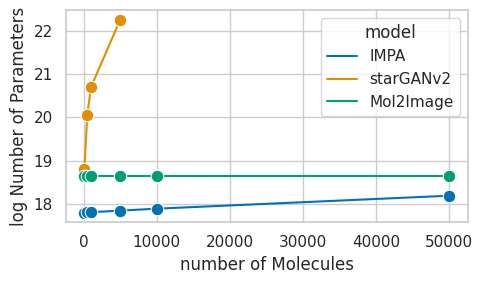

In [28]:
plt.figure(figsize=(5,3))
sns.set(style="whitegrid")

# Plot the lineplot with markers
sns.lineplot(data=results_df, 
             x="number of molecules",
             y="number of parameters", 
             hue="model", 
             marker="o",
             palette="colorblind", 
             markersize=9
            )
# Set the title and labels
# plt.title('number of Parameters vs Number of Molecules')
plt.tight_layout()
plt.xlabel('number of Molecules')
plt.ylabel('log Number of Parameters')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/impa_vs_stargan_vs_mol2image.svg", format="svg")

# Show the plot
plt.show()